### Topic Modeling

In [171]:
#load libraries
import pandas as pd
import numpy as np

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Gensim
from gensim.models import LdaModel
from gensim.models import LdaSeqModel
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

#for plotting
import matplotlib.pyplot as plt


In [54]:
import logging
#for checking convergence of model
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
#
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

In [4]:
#load cleaned data from csv
df = pd.read_csv('data/cleaned_data.csv',dtype=str)
df['amount'].astype(float, errors='ignore')

print(df.head(5))
print(f"shape is: {df.shape}")

  award_id                                              title    amount  \
0  0000009     Design of Cutting Tools for High Speed Milling  280000.0   
1  0000026  A Novel Ultrasonic Cooling Concept for Microel...  292026.0   
2  0000027  Development of a Wireless Sensor to Detect Cra...  238000.0   
3  0000031  Development of Link-to-Column Connections for ...  285000.0   
4  0000033  Integrated study of source, path, and site eff...   84000.0   

                                            abstract  \
0  this project will focus development new cuttin...   
1  the purpose the proposed work design novel coo...   
2  &lt;br/&gt;the objective this research project...   
3  &lt;br/&gt;engelhardt&lt;br/&gt;the objective ...   
4  the kocaeli, turkey, earthquake (m=.) august w...   

                                   division  
0  Div Of Civil, Mechanical, & Manufact Inn  
1     Div Of Electrical, Commun & Cyber Sys  
2  Div Of Civil, Mechanical, & Manufact Inn  
3  Div Of Civil, Mechanical,

In [5]:
df['division'].value_counts()

Division Of Mathematical Sciences                          18567
Translational Impacts                                      12728
Division Of Computer and Network Systems                   12199
Div Of Civil, Mechanical, & Manufact Inn                   11904
Division Of Earth Sciences                                 11573
                                                           ...  
Division Of Design & Manufacturing Innov                       1
Division Of Polar Progrms                                      1
Division of Polar Programs                                     1
Office Of The Director                                         1
National Center for Science and Engineering Statistics.        1
Name: division, Length: 73, dtype: int64

In [6]:
#zoom in on one division
division = 'Div Of Civil, Mechanical, & Manufact Inn'
# division = 'Division Of Mathematical Sciences'

#filter data by division
data = df[df['division']==division]

In [7]:
#add year column
data['year'] = data.loc[:,"award_id"].apply(lambda x: f"20{x[:2]}")

<ipython-input-7-3b36e28d5732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data.loc[:,"award_id"].apply(lambda x: f"20{x[:2]}")


In [8]:
#reset index
data.reset_index(inplace=True,drop=True)

In [19]:
#sample 10 documents from each year and sort data by year
data = data.groupby('year').apply(lambda x: x.sample(10,random_state=42)).reset_index(drop=True)
data.sort_values(by='year',inplace=True)

We will preprocess the entire corpus and handle the representation (BoW) in a single go. That way, we won't have to worry about inconsistent representations among models.

In [21]:
#convert to list
text_data = data['abstract'].tolist()

In [22]:
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(text_data)):
    text_data[idx] = text_data[idx].lower()  
    text_data[idx] = tokenizer.tokenize(text_data[idx])  # Split into words.

#remove numbers
text_data = [[token for token in doc if not token.isnumeric()] for doc in text_data]

#remove words that are only one character.
text_data = [[token for token in doc if len(token) > 1] for doc in text_data]

In [23]:
#look at first document
print(text_data[0][:25])

['lt', 'br', 'gt', 'the', 'objective', 'the', 'research', 'define', 'and', 'conduct', 'experiments', 'thin', 'walled', 'polymer', 'matrix', 'composite', 'pmc', 'tubular', 'specimens', 'having', 'continuous', 'reinforcement', 'fibers', 'methodology', 'for']


In [24]:
lemmatizer = WordNetLemmatizer()
text_data = [[lemmatizer.lemmatize(token) for token in doc] for doc in text_data]

In [25]:
#remove stop words
stop_words = stopwords.words('english')

#extend stop words to corpus specific words
extra_stop_words = ['award','project','research',
                    'investigator','investigators',
                    'investigate','investigates','investigated','investigating',
                    'proposal','proposals','abstract',
                    'nsf','funded','funding',
                    'program','programs',
                    'support','supports','supported',
                    'br','lt','gt','amp','quot','div','lf', #html tags
                    'pi','pis', #principal investigator]
                    'researcher','researchers',
                    'work','works','working',
                    'study','studies','studying',
                    'develop','develops','developed','developing','development',
                    'consider','considered','considering',
                    'include','includes','including',
                    'provide','provides','provided',
                    'use','uses','used',
                    'design','designs','designed','designing',
                    'demonstrate','demonstrates','demonstrated','demonstrating',
                    'result','results','resulted','resulting',
                    'show','shows','showed','showing',
                    'understand','understands','understood','understanding',
                    'determine','determines','determined','determining',
                    'find','finds','found','finding',
                    'identify','identifies','identified','identifying',
                    'evaluate','evaluates','evaluated','evaluating',
                    'examine','examines','examined','examining',
                    'explore','explores','explored','exploring',
                    'new','using','high','low','large','small','different','based',
                    'significant','important','possible','potential','novel',
                    'approach','approaches','approached','approaching',
                    'method','methods',
                    'include','includes','including',
                    'also','well','many','much','several','various','different',
                    'engineering','engineer','engineers','engineered',
                    'system','systems','systematic',
                    'model','models','modeling','modelled','modelled',
                    'analysis','analyse','analyses','analysed','analysing',
                    'method','methods','methodology','methodologies',
                    'specific','specifically',
                    'impact','impacts','impacted','impacting',
                    'profound','profoundly',
                    'significant','significantly',
                    'although','though','however','yet','still','nevertheless',
                    'thus','therefore','hence','consequently',
                    'first','second','third','fourth','fifth','sixth','seventh','eighth','ninth','tenth',
                    'have','has','having','had','ha',
                    'problem','problems',
                    'science','sciences','scientific',
                    'scientist','scientists',
                    'knowledge','knowledges','knowledgable',
]
stop_words.extend(extra_stop_words)

#much faster to convert to set
stop_words = set(stop_words)

In [26]:
#remove stop words
text_data = [[token for token in doc if token not in stop_words] for doc in text_data]

In [27]:
print(text_data[35])

['complex', 'distributed', 'current', 'emerging', 'control', 'application', 'need', 'structure', 'overall', 'control', 'scheme', 'structure', 'motivated', 'number', 'practical', 'reason', 'among', 'cost', 'reliability', 'constrain', 'individual', 'local', 'station', 'interacts', 'overall', 'part', 'information', 'access', 'communication', 'mechanism', 'place', 'control', 'optimal', 'performance', 'structural', 'constraint', 'resent', 'remains', 'open', 'challenge', 'control', 'community', 'recent', 'preliminary', 'principal', 'exposed', 'rich', 'array', 'class', 'proposed', 'nature', 'limitation', 'control', 'performance', 'presence', 'interaction', 'information', 'transmission', 'constraint', 'effective', 'control', 'synthesis', 'addition', 'theoretical', 'algorithmic', 'major', 'objective', 'proposed', 'utilize', 'structured', 'control', 'imaging', 'technology', 'utilize', 'micro', 'cantilever', 'particularly', 'context', 'atomic', 'force', 'microscopy', 'apart', 'theoretical', 'prac

In [28]:
#look at most frequent words in data
from collections import Counter
from itertools import chain
from nltk import FreqDist

#flatten list of lists
all_words = list(chain(*text_data))


In [29]:
all_words_freq = FreqDist(all_words)

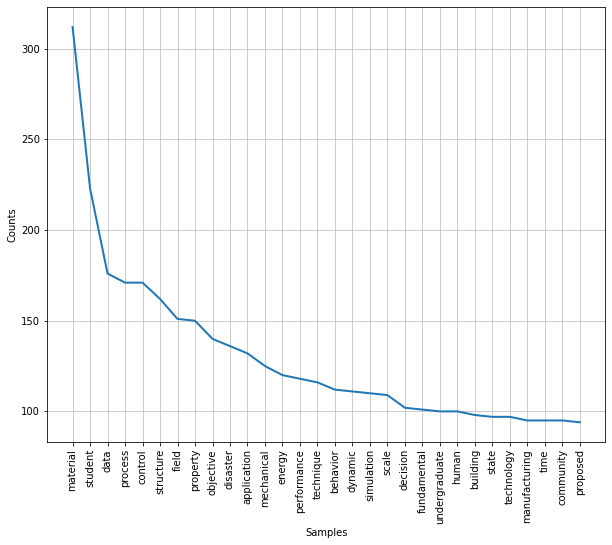

In [30]:
#plot most frequent words
plt.figure(figsize=(10,8))
all_words_freq.plot(30, cumulative=False)

#increase font size for plot
plt.rcParams.update({'font.size': 15})

In [31]:
#bigrams and trigrams. let's us capture useful phrases such as 'machine_learning' or 'quantum_computing'
bigram = Phrases(text_data, min_count=5, threshold=50) 
trigram = Phrases(bigram[text_data], threshold=50) 

# exporting trained models for bigrams and trigrams. faster.
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


c:\Users\samael\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [37]:
#see example of bigrams + trigrams
print([x for x in bigram_mod[text_data[7]] if '_' in x])

print([x for x in trigram_mod[text_data[7]] if '_' in x])

['multi_disciplinary', 'united_state', 'full_scale', 'multi_disciplinary']
['multi_disciplinary', 'full_scale', 'multi_disciplinary']


In [38]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(text_data)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [39]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in text_data]

In [40]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 265
Number of documents: 220


In [50]:
# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

22

In [55]:
ntopics = 10
#train model on portion of the corpus
def train_model(corpus, id2word, num_topics=ntopics,):
    lda = LdaSeqModel(
            corpus=corpus,
            time_slice=[10 for i in range(len(data.year.unique()))],
            id2word=id2word,
            chunksize=50,
            num_topics=num_topics,
            passes=5,
            lda_inference_max_iter=5,
        )
    return lda

In [56]:
model = train_model(corpus,id2word,num_topics=ntopics)

2024-01-25 15:43:27,819 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


c:\Users\samael\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\models\ldaseqmodel.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [183]:
model.save('models/lda_seq_model_10topics.model') # Save model to disk.

In [185]:
# Load a potentially pre-trained model from disk. #needs some testing for dictionary, corpus, and id2word
test_model = LdaSeqModel.load('models/lda_seq_model_10topics.model')

In [190]:
(model.doc_topics(0)==test_model.doc_topics(0)).all()

True

In [93]:
#how to see a topic over time
topic_num = 0
model.print_topic_times(topic=topic_num) #list of top k words for topic over time

[[('simulation', 0.06352394746822891),
  ('framework', 0.03652212222700615),
  ('workshop', 0.0341913916853499),
  ('optimization', 0.03328908375364188),
  ('proposed', 0.030018489898984143),
  ('theory', 0.02960116034801896),
  ('computational', 0.027985073512027697),
  ('complex', 0.020252192133691876),
  ('space', 0.019226693232912623),
  ('solution', 0.01857567291576981),
  ('type', 0.01786720329586709),
  ('mathematical', 0.01750940976542643),
  ('performance', 0.016944609495230988),
  ('resource', 0.016914789425556184),
  ('theoretical', 0.015629313730677476),
  ('expected', 0.015272151066574213),
  ('one', 0.015250967723408906),
  ('technique', 0.015224722521532128),
  ('via', 0.014764776391471906),
  ('example', 0.014485221141370104)],
 [('simulation', 0.06310755236308015),
  ('framework', 0.03625005709077059),
  ('workshop', 0.03454257575816044),
  ('optimization', 0.03362779508678485),
  ('proposed', 0.030120537509235427),
  ('theory', 0.02960072249503139),
  ('computational'

In [132]:
#infer topics for a document
model.doc_topics(0)

array([2.16785068e-01, 7.09219858e-04, 7.09219858e-04, 7.09219858e-04,
       7.09219858e-04, 7.09219858e-04, 7.09219858e-04, 7.09219858e-04,
       7.09219858e-04, 7.77541173e-01])

In [59]:
print(dir(model))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_save_specials', '_smart_save', 'alphas', 'corpus_len', 'doc_topics', 'dtm_coherence', 'dtm_vis', 'fit_lda_seq', 'fit_lda_seq_topics', 'gammas', 'id2word', 'inferDTMseq', 'influence', 'influence_sum_lgl', 'init_ldaseq_ss', 'lda_seq_infer', 'load', 'make_lda_seq_slice', 'max_doc_len', 'num_time_slices', 'num_topics', 'print_topic', 'print_topic_times', 'print_topics', 'renormalized_influence', 'save', 'sstats', 'time_slice', 'top_doc_phis', 'topic_chains', 'vocab_len']


In [170]:
model.print_topics()[0] #[topic_num] #list of top k words for topic

[('simulation', 0.06352394746822891),
 ('framework', 0.03652212222700615),
 ('workshop', 0.0341913916853499),
 ('optimization', 0.03328908375364188),
 ('proposed', 0.030018489898984143),
 ('theory', 0.02960116034801896),
 ('computational', 0.027985073512027697),
 ('complex', 0.020252192133691876),
 ('space', 0.019226693232912623),
 ('solution', 0.01857567291576981),
 ('type', 0.01786720329586709),
 ('mathematical', 0.01750940976542643),
 ('performance', 0.016944609495230988),
 ('resource', 0.016914789425556184),
 ('theoretical', 0.015629313730677476),
 ('expected', 0.015272151066574213),
 ('one', 0.015250967723408906),
 ('technique', 0.015224722521532128),
 ('via', 0.014764776391471906),
 ('example', 0.014485221141370104)]

In [128]:
#document embedding
model[corpus[0]]

array([2.24515257e-01, 7.09219858e-04, 7.09219858e-04, 7.09219858e-04,
       7.09219858e-04, 7.09219858e-04, 7.09219858e-04, 7.09219858e-04,
       7.09219858e-04, 7.69810984e-01])

# TODO
- figure out how to get a visualization 
- how to assign dollars to each topic (would like this by year)
- how to interpret topics
- 